# Introducción a PyMC

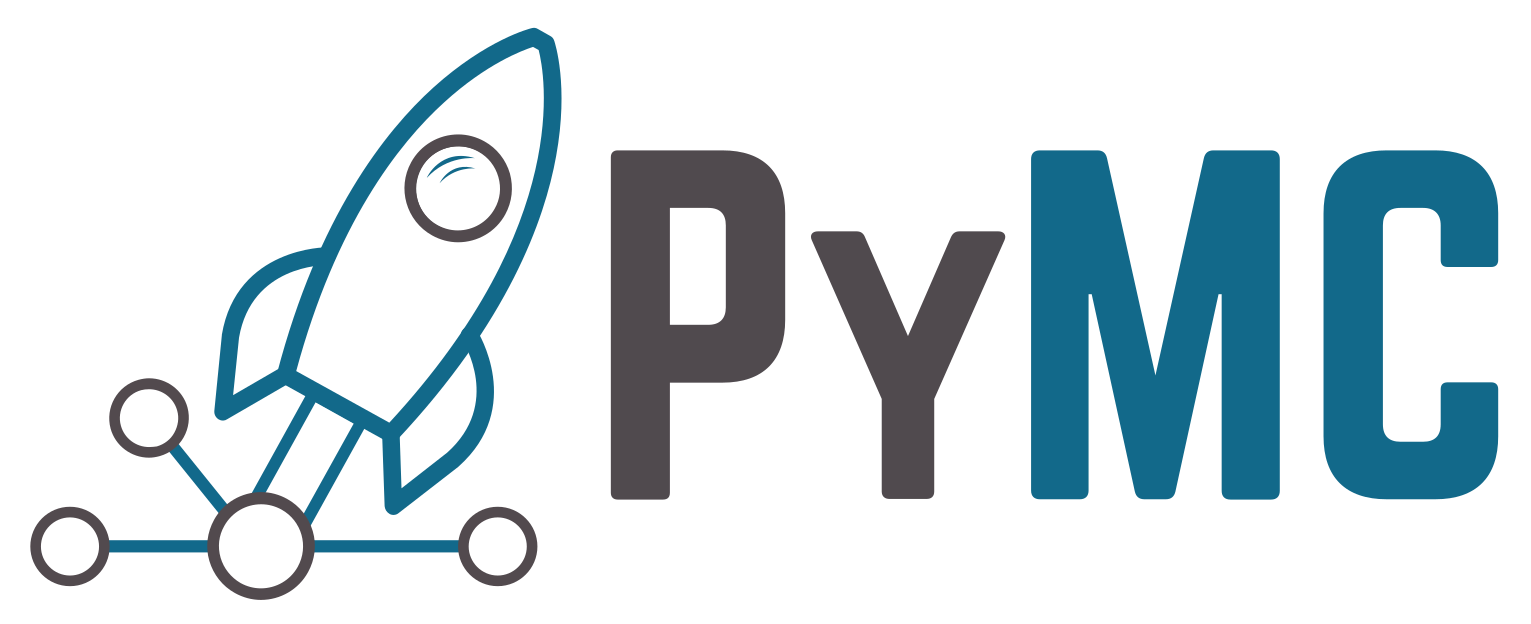

Hasta ahora hemos visto modelos Bayesianos básicos usando un enfoque de inferencia exacta. Vimos las dificultades de este enfoque y que no es aplicable en general, y por eso estudiamos métodos de muestreo que nos permiten hacer inferencia aproximada de la distribución posterior. En este módulo estudiaremos la API de la librería `PyMC`, que nos permite hacer inferencia aproximada sin preocuparnos mucho por los motores de inferencia como tal, y sí en el modelado.

> **Objetivos:**
> - Estudiar la API de `PyMC`, en particular las funciones para crear modelos, definir variables aleatorias previas y verosimilitudes, hacer inferencia y el muestreo de la distribución posterior predictiva.

> **Referencias:**
> - https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc as pm

In [3]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## 1. Creación de modelos

Los modelos en PyMC se crean con la clase `Model`. Dentro de esta clase, se codifican todas las variables aleatorias y sus relaciones, y la clase se encarga de calcular la log probabilidad del modelo y sus gradientes (necesarias para H-MCMC). Normalmente usamos el administrador de contextos para instanciar el modelo:

In [ ]:
# Instanciación básica de un modelo
with pm.Model() as model:
    # Definición de las variables aleatorias (modelo)
    pass

_______

(Paréntesis)

In [5]:
# Sin el "context manager"
file = open("hello_world.txt", "w")
file.write("Hello, World!")
file.close()

In [6]:
# Con el "context manager"
with open("hello_world2.txt", "w") as file:
    file.write("Hello, World New!")

In [7]:
file = open("hello_world3.txt", "w")
file.write("Hello, World Bad!")

17

In [8]:
file.close()

__________

Dentro del modelo, definimos las variables aleatorias necesarias:

In [11]:
# Modelo básico: verosimilitud normal con varianza conocida, previa normal
with pm.Model() as model:
    # Previa
    mu = pm.Normal("mu", mu=0, sigma=1)
    # Verosimilitud
    y = pm.Normal("y", mu=mu, sigma=2, observed=rng.normal(0, 1, 100))    

In [12]:
# Inspección de las variables aleatorias básicas
model.basic_RVs

[mu ~ N(0, 1), y ~ N(mu, 2)]

In [13]:
# Inspección de las variables aleatorias libres
model.free_RVs

[mu ~ N(0, 1)]

In [14]:
# Inspección de las variables aleatorias observadas
model.observed_RVs

[y ~ N(mu, 2)]

In [15]:
# Cálculo de logp
model.compile_logp()({"mu": 0})

array(-177.03384519)

In [16]:
model.compile_dlogp()({"mu": 0})

array([3.63205179])

## 2. Distribuciones de probabilidad

Todo programa probabilístico consiste de variables aleatorias observadas y no observadas. 

- Las variables aleatorias observadas, se definen a través de distribuciones de verosimilitud (recordar verosimilitud = p(datos | parámetros)),
- mientras que las variables aleatorias no observadas se definien a través de distribuciones previas.

Acá [el catálogo de distribuciones de probabilidad de PyMC](https://www.pymc.io/projects/docs/en/stable/api/distributions.html#api-distributions).

### Variables aleatorias no observadas

Las variables aleatorias no observadas tienen como argumentos:

- name: str
- parameter keyword arguments

Por ejemplo, para una distribución normal:

In [17]:
# Variable aleatoria normal x no observada (previa)
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

In [18]:
# Logp en cero de la variable x
pm.logp(x ,0).eval()

array(-0.91893853)

### Variables aleatorias observadas

Tienen los mismos argumentos que las no observadas, y adicionalmente requieren que pasemos los datos observados:

- observed

In [19]:
# Variable aleatoria normal x observada (verosimilitud)
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1, observed=rng.normal(0, 1, 100))

### Transformaciones deterministas

PyMC permite hacer cálculos algebraicos con variables aleatorias:

In [20]:
# Variables aleatorias no observadas x, y y transformaciones deterministas
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    # x + 2
    plus_2 = x + 2
    # x + y
    sum_x_y = x + y
    # x ** 2
    squared = x ** 2
    # sin(x)
    sin_x = pm.math.sin(x)

Estas transformaciones trabajan correctamente, sin embargo, los resultados de las mismas no se guardan automáticamente. Si queremos que PyMC lleve registro de las variables transformadas, debemos usar `pm.Deterministic`:

In [ ]:
# Uso de deterministic
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    # x + 2
    plus_2 = pm.Deterministic("plus_2", x + 2)
    # x + y
    sum_x_y = pm.Deterministic("sum_x_y", x + y)
    # x ** 2
    squared = pm.Deterministic("squared", x ** 2)
    # sin(x)
    sin_x = pm.Deterministic("sin_x", pm.math.sin(x))

### Variables aleatorias de alto orden

Ya vimos cómo crear variables aleatorias de una dimension (escalares). En varios contextos querremos crear variables aleatorias de múltiples dimensiones.

La mejor práctica para hacer esto es:

In [21]:
# Coordenadas por ciudad
coords = {"cities": ["Santiago", "Mumbai", "Tokyo"]}
# Modelo de múltiples variables aleatorias relativas a ciudades
with pm.Model(coords=coords) as model:
    # Previa normal por ciudad
    x = pm.Normal("x", mu=0, sigma=1, dims="cities")

In [23]:
# Shape de las variables aleatorias
model.eval_rv_shapes()

{'x': (3,)}

## 3. Inferencia

Una vez hemos definido nuestro modelo, debemos aplicar inferencia para aproximar la distribución posterior.

### Muestreo
El punto principal de entrada a los algoritmos de muestreo por MCMC es con la función `pm.sample()`. Por defecto, esta función asigna el muestreador adecuado. La función `pm.sample()` devuelve un objeto `arviz.InferenceData`, los cuales contienen toda la información del muestreo realizado. Adicionalmente, se pueden enriquecer con más datos como las muestras de la **posterior predictiva**, y combinan perfectamente con la librería ArviZ para visualización.

Retomemos el modelo básico: verosimilitud normal con varianza conocida, previa normal

In [24]:
# Modelo básico: verosimilitud normal con varianza conocida, previa normal
with pm.Model() as model:
    # Previa
    mu = pm.Normal("mu", mu=0, sigma=1)
    # Verosimilitud
    y = pm.Normal("y", mu=mu, sigma=2, observed=rng.normal(0, 1, 100))    
    # muestreo
    idata = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


In [28]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

El modelo contiene exclusivamente variables continuas, por lo que PyMC asignó el muestreador NUTS, el cuál es un muestreador basado en HMC con ciertas características adicionales, y es bastante efectivo para incluso modelos complejos.

Si no se especifican el número de `chains` (cadenas de Markov), se determina automáticamente por el número de núcleos CPU disponibles:

In [25]:
# Dims de las posteriores
idata.posterior.dims

FrozenMappingWarningOnValuesAccess({'chain': 4, 'draw': 2000})

Entonces, podemos observar que se muestrearon 2000 valores de cada cadena:

In [26]:
# Para mu, shape
idata.posterior["mu"].shape

(4, 2000)

Si queremos observar las muestras de una cadena en específico:

In [27]:
# Para mu, cadena 2, shape
idata.posterior["mu"].sel(chain=2).shape

(2000,)

### Analizamos los resultados

El gráfico más común para analiza rlos resultados es el llamado trace-plot:

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

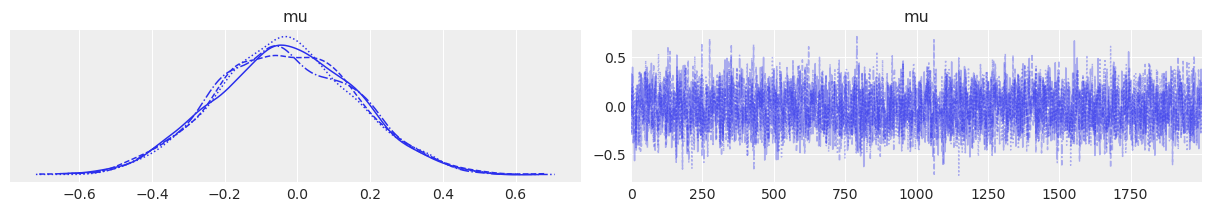

In [43]:
# plot_trace
az.plot_trace(idata)

Del lado izquierdo observamos las distribuciones posteriores ajustadas a las muestras (para cada cadena), mientras que del lado derecho observamos las muestras como tal.

También podemos ver algunos estadísticos en una tabla:

In [ ]:
# summary
az.summary(idata, hdi_prob=0.89)

,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.033,0.195,-0.532,0.45,0.003,0.002,3551.0,5931.0,1.0


Y la misma información de forma gráfica:

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

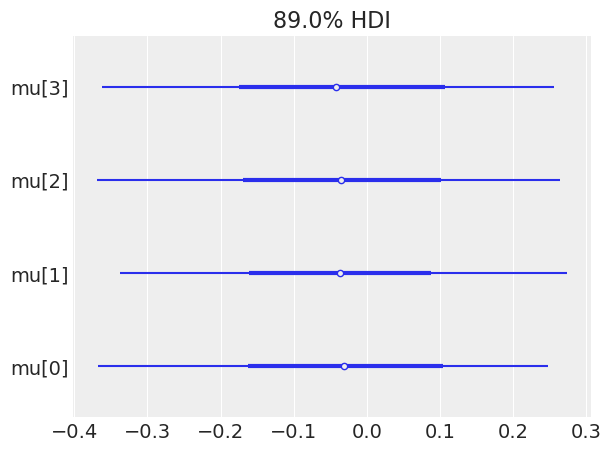

In [36]:
# plot_forest
az.plot_forest(idata, hdi_prob=0.89)

Finalmente, una gráfica de la posterior:

<Axes: title={'center': 'mu'}>

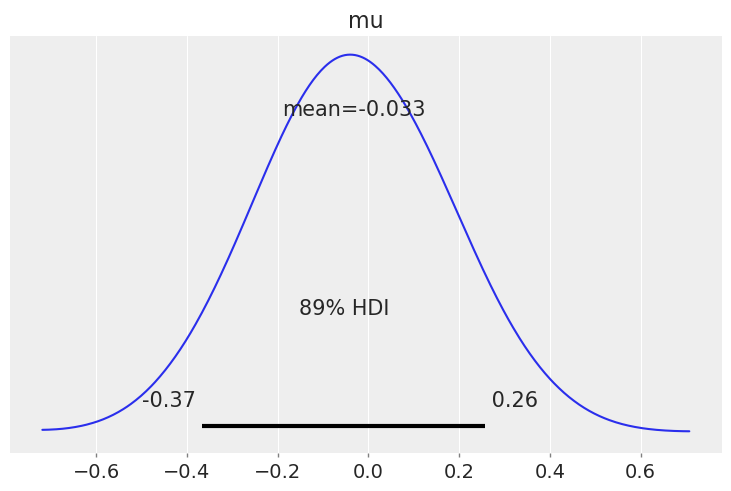

In [40]:
# plot_posterior
az.plot_posterior(idata, hdi_prob=0.89, bw=0.1)

In [52]:
idata.posterior["mu"].sel(chain=1).to_pandas()

draw
0       0.150605
1      -0.288795
2      -0.259240
3      -0.259240
4       0.214973
          ...   
1995   -0.190479
1996   -0.299485
1997   -0.138771
1998   -0.045243
1999   -0.045243
Length: 2000, dtype: float64

## 4. Muestreo posterior predictivo

En el módulo 2, cuando vimos el tema de actualización Beyesiana, comentamos que después de encontrar la distribución posterior, la podíamos usar para hacer predicciones del experimento. En este contexto, estamos generando muestras para aproximar la posterior, y podemos usar dichas muestras como si fueran muestras de la posterior para hacer predicciones:

In [ ]:
# Nuevo modelo, incluyendo previa para la desviación estándar
data = rng.standard_normal(100)
with pm.Model() as model:
    # Previas
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    # Verosimilitud
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)
    # Muestreo de las distribuciones posteriores
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [54]:
# Incluimos muestras de la posterior predictiva
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


In [55]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

c:\Users\esjim\anaconda3\envs\mebo2024_v4\lib\site-packages\arviz\plots\ppcplot.py:264: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
c:\Users\esjim\anaconda3\envs\mebo2024_v4\lib\site-packages\arviz\plots\ppcplot.py:268: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


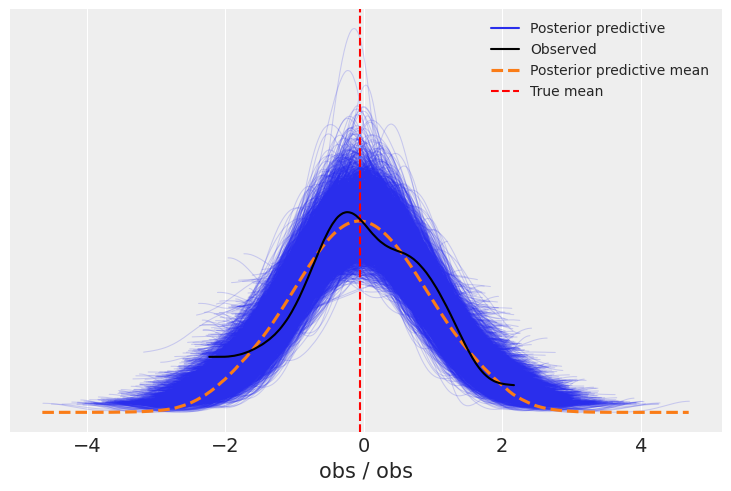

In [56]:
# Gráfica de las muestras de la posterior predictiva, la media de dichas muestras
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

### Predicciones sobre datos no vistos

En muchas ocasiones queremos predecir datos no vistos por el modelo. Esto es especialmente relevante en "Probabilistic Machine Learning" y "Bayesian Deep Learning". 

`PyMC` incluye una variable tipo `MutableData` que es apropiada para estos usos. Este tipo de variable permite que los valores de los datos puedan ser cambiados posteriormente.

Esta distinción es muy importante, dado que internamente los modelos en `PyMC` son expresiones simbólicas gigantes, por lo que cuando pasamos datos observados, `PyMC` hace optimizaciones tratando estos datos como constantes y no como variables. Por tanto, si se necesita cambiar estos datos después, no sería posible si no usamos variables tipo `MutableData`.

El ejemplo a continuación es de una regresión logística:

In [57]:
x = rng.standard_normal(100)
y = x > 0

coords = {"idx": np.arange(100)}
with pm.Model() as model:
    # Variables mutables que pueden ser cambiadas después de la creación del modelo
    x_obs = pm.MutableData("x_obs", x, dims="idx")
    y_obs = pm.MutableData("y_obs", y, dims="idx")

    coeff = pm.Normal("x", mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_obs)
    pm.Bernoulli("obs", p=logistic, observed=y_obs, dims="idx")
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [58]:
with model:
    # Cambiamos los datos observados
    pm.set_data(
        {
            "x_obs": [-1, 0, 1.0],
            "y_obs": [0, 0, 0],
        },
        coords={"idx": [1001, 1002, 1003]},
    )

    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


In [ ]:
idata.posterior_predictive["obs"].mean(dim=["draw", "chain"])

<xarray.DataArray 'obs' (idx: 3)> Size: 24B
array([0.027  , 0.496  , 0.97225])
Coordinates:
  * idx      (idx) int32 12B 1001 1002 1003

: 

# Anuncions

## 1. Quiz de introducción a PyMC la siguiente clase (martes 12 de nov).